In [ ]:
import os, random, shutil

def randomize_datasets(pvTrain, pvTest, pvValid, path, typeML):
    
    try:
        os.mkdir(path+'valid')
    except OSError:
        pass
    
    try:
        os.mkdir(path+'train')
    except OSError:
        pass
    
    try:
        os.mkdir(path+'test')
    except OSError:
        pass
    
    totalFiles = len(next(os.walk(path+typeML))[2])
    trainMove = 0
    testMove = 0
    validMove = 0
    
    
    # n%20 < 16 put in folder train
    # elif x%20 < 19 put in folder test
    # else (x%20 == 19) put in folder verify
    
    print ("Moving {0} files...".format(totalFiles))
    x = 0
    while (x!=totalFiles):
        random.seed();
        for root, dirs, files in os.walk(path+typeML):
            for name in files:
                chance = random.uniform(0,99)
                rfile=os.path.join(root, name)    

                if (chance % 100 < pvValid):
                    try:
                        os.mkdir(path+'valid/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'valid/'+typeML+'/')
                    validMove = validMove + 1
                    
                elif (chance % 100 < pvValid + pvTest):
                    try:
                        os.mkdir(path+'test/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'test/'+typeML+'/')
                    testMove = testMove + 1
                    
                else:
                    try:
                        os.mkdir(path+'train/'+typeML+'/')
                    except OSError:
                        pass
                    shutil.copy(rfile, path+'train/'+typeML+'/')
                    trainMove = trainMove + 1
                x = x + 1
        
    print ("Moved {0} to train!".format(trainMove))
    print ("Moved {0} to test!".format(testMove))
    print ("Moved {0} to valid!".format(validMove))
 
    
randomize_datasets(80, 15, 5, 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\', 'clench_images')
randomize_datasets(80, 15, 5, 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\', 'spidey_images')


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = 'C:\\Users\\aashi\\OneDrive\\Desktop\\school\\SFSU\\semester4 F19\\ENGR 478\\EMILA-CODE\\MachineLearning\\'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    part_files = np.array(data['filenames'])
    part_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return part_files, part_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(bigPath + 'train')
test_files, test_targets = load_dataset(bigPath +'test')
valid_files, valid_targets = load_dataset(bigPath +'valid')

print('There are %d training part images.' % len(train_files))
print('There are %d validation part images.' % len(valid_files))
print('There are %d test part images.'% len(test_files))

Using TensorFlow backend.


There are 138 training part images.
There are 9 validation part images.
There are 26 test part images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 86.03it/s]


In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import multi_gpu_model
import tensorflow as tf

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
__________

In [4]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 100
batch_size=20

bestModelSavedName = "firstBench.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets), 
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Train on 138 samples, validate on 9 samples
Epoch 1/100
 - 7s - loss: 0.9247 - acc: 0.4638 - val_loss: 0.6956 - val_acc: 0.4444

Epoch 00001: val_loss improved from inf to 0.69557, saving model to firstBench.hdf5
Epoch 2/100
 - 2s - loss: 0.6994 - acc: 0.5109 - val_loss: 0.6928 - val_acc: 0.5556

Epoch 00002: val_loss improved from 0.69557 to 0.69278, saving model to firstBench.hdf5
Epoch 3/100
 - 2s - loss: 0.7070 - acc: 0.5217 - val_loss: 0.6929 - val_acc: 0.5556

Epoch 00003: val_loss did not improve from 0.69278
Epoch 4/100
 - 2s - loss: 0.7106 - acc: 0.4565 - val_loss: 0.6939 - val_acc: 0.4444

Epoch 00004: val_loss did not improve from 0.69278
Epoch 5/100
 - 2s - loss: 0.7089 - acc: 0.4638 - val_loss: 0.6924 - val_acc: 0.5556

Epoch 00005: val_loss improved from 0.69278 to 0.69241, saving model to firstBench.hdf5
Epoch 6/100
 - 2s - loss: 0.6971 - acc: 0.4891 - val_loss: 0.6941 - val_acc: 0.4444

Epoch 00006: val_loss did not improve from 0.69241
Epoch 7/100
 - 2s - loss: 0.7039 

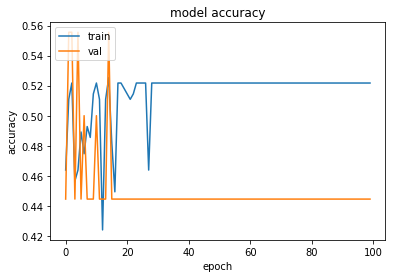

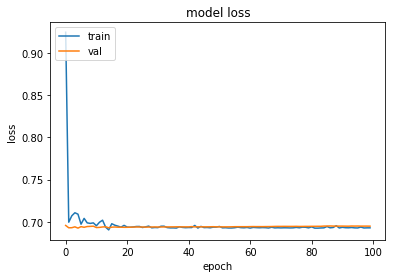

In [5]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
from sklearn.metrics import f1_score
import pandas as pd

model.load_weights(bestModelSavedName)

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Test accuracy: 53.8462%


c:\users\aashi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fscore: [0.  0.7]
Predicted   1  All
Actual            
0          12   12
1          14   14
All        26   26
